In [1]:
import pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import KFold
from sklearn import svm

import matplotlib.pyplot as plt

In [2]:
# utility function to read from a text file
def read_file(filename):
    with open(filename) as file:
        lines = file.readlines()
        clean = [x.strip().lower() for x in lines if x.strip()!=""]
        return clean

In [3]:
# prapares the dataset.
# reads positive/negative cases and creates a dataframe.
# if balance is True, it will balance dataset by replicating the positive cases 
# so the represtantation gap will be closed.

# balancing dataset by repeating the positive cases
# https://www.kdnuggets.com/2017/06/7-techniques-handle-imbalanced-data.html
# handling imbalanced data 2.2
def prepare_dataset(balance=True):
    def prapare_df(file, label):
        lines = read_file(file)
        df = pd.DataFrame()
        df['lines'] = lines
        df['target'] = label
        return df
    
    df = prapare_df('negative.txt', 0)
    pos = prapare_df('positive.txt', 1)
    
    if balance == False:
        df = df.append(pos, ignore_index=True)
    
    else:
        times = int(len(df)/len(pos))
        for i in range(times):
            df = df.append(pos, ignore_index=True)
    
    return df

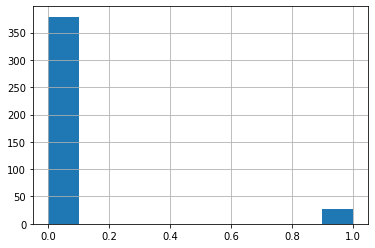

In [4]:
df = prepare_dataset(False)
df['target'].hist()

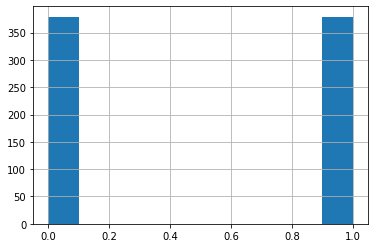

In [5]:
df = prepare_dataset(True)
df['target'].hist()

In [6]:
df.head()

,lines,target
0,i know this happens,0
1,say sorry,0
2,i know is it happened this,0
3,you meet this mess,0
4,what do you say,0


In [7]:
df.tail()

,lines,target
752,set a timer for 2 minutes sophia,1
753,sophia please take a note,1
754,sophia who is the author of lord of the rings ...,1
755,what's the capital of turkey sophia,1
756,hey sofia how are you,1


In [8]:
def assertions(model, vectorizer):
    sents = []
    predictions = []
    results = []
    y_true = []
    def run(sentences, expect, ifNot):
        for sent in sentences:
            pred = predict(sent, model, vectorizer)[0] == 1
            result = 'Correct' if pred == expect else ifNot
            sents.append(sent)
            predictions.append(pred)
            y_true.append(expect)
            results.append(result)
            
    positives = [
        'add milk to my shopping list sophia',
        'can you tell me sophia what time it is'
    ]
    
    run(positives, True, 'False negative')
        
    negatives = [
        'what time is it',
        'do you think that sophia can answer to this',
        'why dont we ask this to sophia',
        'sophia can also take notes'
    ]
    
    run(negatives, False, 'False positive')
    
    df = pd.DataFrame()
    df['Sentences'] = sents
    df['Predictions'] = predictions
    df['Expect'] = y_true
    df['Results'] = results
    
    return df

In [9]:
def predict(sentences, model, vectorizer):
    sentences = sentences if isinstance(sentences, list) else [sentences]
    vector = vectorizer.transform(sentences)
    return model.predict(vector)

In [10]:
def save_models(
    model, 
    vectorizer,    
    model_name = 'model.pickle',
    vector_name = 'vector.pickle'
):
    pickle.dump(model, open(model_name, 'wb'))
    pickle.dump(vectorizer, open(vector_name, 'wb'))

In [11]:
# shows feature importances (for linear models)
def show_important_features(model, vectorizer):
    feature_names = vectorizer.get_feature_names()
    df = pd.DataFrame()
    df['feature'] = feature_names
    df['score'] = model.coef_[0]
    df.sort_values(by='score', inplace=True, ascending=False)
    return df
    

In [12]:
# def create_train_test(df=df):
#     X = df[['lines']]
#     y = df['target']
#     X_train, X_test, y_train, y_test = train_test_split(X,y)
#     return X_train, X_test, y_train, y_test

In [13]:
# X_train, X_test, y_train, y_test = create_train_test()

# y_train.hist()
# y_test.hist()

In [14]:
# def train_and_test(model, vectorizer):
#     X_train_matrix = vectorizer.fit_transform(X_train['lines'])
#     model.fit(X_train_matrix, y_train)
    
#     X_test_matrix = vectorizer.transform(X_test['lines'])
#     y_pred = model.predict(X_test_matrix)
# #     y_pred_prob = model.predict_proba(X_test_matrix)
    
#     acc_score = accuracy_score(y_test, y_pred)
#     f1__score = f1_score(y_test, y_pred)
# #     roc_score = roc_auc_score(y_test, y_pred_prob[:,1])
#     print('Accuracy Score : ', acc_score)
#     print('F1 Score: ', f1__score)
# #     print('ROC Score :' , roc_score)
#     print ("")
#     return assertions(model, vectorizer)

In [15]:
score_funcs = [
    ('Accuracy', accuracy_score),
    ('Precision', precision_score),
    ('Recall', recall_score),
    ('F1 Score', f1_score)
]

model_scores = dict()

def train_and_test(model, vectorizer, score_func_list=score_funcs, model_name=None):
    fold = KFold(n_splits=4, random_state=10, shuffle=True)
    
    X = df[['lines']]
    y = df['target']
    
    scores = dict()
    for (name, func) in score_func_list:
        scores[name] = [] 
    
    for train_index, test_index in fold.split(X):
        X_train, X_test = X.loc[ train_index], X.loc[test_index]
        y_train, y_test = y[train_index], y[test_index]
    
        X_train_matrix = vectorizer.fit_transform(X_train['lines'])
        model.fit(X_train_matrix, y_train)
        
        X_test_matrix = vectorizer.transform(X_test['lines'])
        y_pred = model.predict(X_test_matrix)
        # print(sum(y_pred), sum(y_test))

        for (name, func) in score_func_list: 
            score = func(y_test, y_pred)
            scores[name].append(score)

    if model_name != None:
        model_scores[model_name] = []
        
    for (name, func) in score_func_list:
        avg_score = np.mean(scores[name])
        print(name, ': ', avg_score)
        
        if model_name != None:
            model_scores[model_name].append(avg_score)
        
    
    return assertions(model, vectorizer)

In [16]:
# https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

In [18]:
model1 = svm.SVC(gamma='auto')
vectorizer = CountVectorizer()

train_and_test(model1, vectorizer, model_name='SVC')

Accuracy :  0.906265664160401
Precision :  0.9831470800288392
Recall :  0.8246891070593735
F1 Score :  0.8965499787167102


,Sentences,Predictions,Expect,Results
0,add milk to my shopping list sophia,True,True,Correct
1,can you tell me sophia what time it is,True,True,Correct
2,what time is it,False,False,Correct
3,do you think that sophia can answer to this,True,False,False positive
4,why dont we ask this to sophia,False,False,Correct
5,sophia can also take notes,True,False,False positive


In [19]:
# Bigram Counts
model2 = svm.SVC(probability=True, gamma='auto')
bigram_vectorizer = CountVectorizer(ngram_range=(1, 2))

# bigram_vectorizer.get_feature_names()
train_and_test(model2, bigram_vectorizer, model_name='SVC_bigram')

Accuracy :  0.5482525758841549
Precision :  0.6469403894075204
Recall :  0.765
F1 Score :  0.5472855631862806


,Sentences,Predictions,Expect,Results
0,add milk to my shopping list sophia,False,True,False negative
1,can you tell me sophia what time it is,True,True,Correct
2,what time is it,False,False,Correct
3,do you think that sophia can answer to this,False,False,Correct
4,why dont we ask this to sophia,False,False,Correct
5,sophia can also take notes,False,False,Correct


In [20]:
# model3 = svm.SVC(probability=True, gamma='auto')
# vectorizer3 = CountVectorizer(ngram_range=(2, 2))
# train_and_test(model3, vectorizer3)

# # a lot worse

In [21]:
from sklearn.naive_bayes import MultinomialNB

In [22]:
nb = MultinomialNB()
vectorizer = CountVectorizer()

train_and_test(nb, vectorizer, model_name='MultinomialNB')

Accuracy :  0.9247215260373156
Precision :  0.8689774578503893
Recall :  1.0
F1 Score :  0.9296522878660851


,Sentences,Predictions,Expect,Results
0,add milk to my shopping list sophia,True,True,Correct
1,can you tell me sophia what time it is,True,True,Correct
2,what time is it,True,False,False positive
3,do you think that sophia can answer to this,False,False,Correct
4,why dont we ask this to sophia,False,False,Correct
5,sophia can also take notes,True,False,False positive


In [23]:
nb = MultinomialNB()
bigram_vectorizer = CountVectorizer(ngram_range=(1, 2))

# bigram_vectorizer.get_feature_names()
train_and_test(model2, bigram_vectorizer, model_name='MultinomialNB_bigram')

Accuracy :  0.5482525758841549
Precision :  0.6469403894075204
Recall :  0.765
F1 Score :  0.5472855631862806


,Sentences,Predictions,Expect,Results
0,add milk to my shopping list sophia,False,True,False negative
1,can you tell me sophia what time it is,True,True,Correct
2,what time is it,False,False,Correct
3,do you think that sophia can answer to this,False,False,Correct
4,why dont we ask this to sophia,False,False,Correct
5,sophia can also take notes,False,False,Correct


In [24]:
from sklearn.linear_model import SGDClassifier

sgd_model1 = SGDClassifier()
vectorizer = CountVectorizer()

train_and_test(sgd_model1, vectorizer, model_name='SGDClassifier')

Accuracy :  0.9894458368142579
Precision :  0.979441014354075
Recall :  1.0
F1 Score :  0.9895733448334374


,Sentences,Predictions,Expect,Results
0,add milk to my shopping list sophia,True,True,Correct
1,can you tell me sophia what time it is,True,True,Correct
2,what time is it,True,False,False positive
3,do you think that sophia can answer to this,False,False,Correct
4,why dont we ask this to sophia,False,False,Correct
5,sophia can also take notes,True,False,False positive


In [25]:
from sklearn.linear_model import LogisticRegression

regr = LogisticRegression(solver='lbfgs')
vectorizer = CountVectorizer()

train_and_test(regr, vectorizer, model_name='LogisticRegression')

Accuracy :  0.9934071289334447
Precision :  0.9868683510638298
Recall :  1.0
F1 Score :  0.9933435739887353


,Sentences,Predictions,Expect,Results
0,add milk to my shopping list sophia,True,True,Correct
1,can you tell me sophia what time it is,True,True,Correct
2,what time is it,False,False,Correct
3,do you think that sophia can answer to this,False,False,Correct
4,why dont we ask this to sophia,False,False,Correct
5,sophia can also take notes,True,False,False positive


In [26]:
# show_important_features(regr, vectorizer)[:10]

In [27]:
# regr = LogisticRegression(solver='newton-cg')
# train_and_test(regr, vectorizer)
# no difference

In [28]:
def show_model_results():
    score_df = pd.DataFrame(model_scores)
    score_df.index = [name for name, _ in score_funcs]
    score_df = score_df.T
    score_df.sort_values(by='Accuracy', inplace=True, ascending=False)
    return score_df

show_model_results()
# model_scores

,Accuracy,Precision,Recall,F1 Score
LogisticRegression,0.993407,0.986868,1.000000,0.993344
SGDClassifier,0.989446,0.979441,1.000000,0.989573
MultinomialNB,0.924722,0.868977,1.000000,0.929652
SVC,0.906266,0.983147,0.824689,0.896550
SVC_bigram,0.548253,0.646940,0.765000,0.547286
MultinomialNB_bigram,0.548253,0.646940,0.765000,0.547286


In [29]:
# saving models to be used by the server
save_models(regr, vectorizer)

## Bias

The modals overall performed really well. This raised a suspicion. Reasons may be:
The results may be different, if text gathered was from adults talk where model may not predict so easily.
While recording we were facing each other (not facing the computer where the mic is) so the transcription was not very accurate where I was recording the positive cases, I was facing to the computer which resulted in better transcription. 